<a href="https://colab.research.google.com/github/lakshaygoyal425/Pytorch/blob/master/Transfer_Learning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks"

 Autograd.ipynb				       Untitled0.ipynb
'Basic NN.ipynb'			      'Untitled (1)'
'Data Loading And Processing Tutorial.ipynb'   Untitled1.ipynb
 hymenoptera_data			       Untitled2.ipynb
'Neural Network.ipynb'			       Untitled3.ipynb
'Pytorch basics.ipynb'			       Untitled4.ipynb
'Training a Classifier.ipynb'		       Untitled5.ipynb
'Transfer Learning Tutorial.ipynb'	       Untitled6.ipynb
 Untitled


In [0]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "./drive/My Drive/Colab Notebooks/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

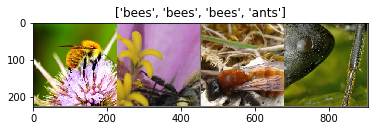

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 44693308.15it/s]


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6535 Acc: 0.7087
val Loss: 0.2330 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.7290 Acc: 0.7087
val Loss: 0.1878 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5517 Acc: 0.8110
val Loss: 0.1996 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5806 Acc: 0.7992
val Loss: 0.2512 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4450 Acc: 0.8307
val Loss: 0.2931 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5135 Acc: 0.7835
val Loss: 0.2306 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3983 Acc: 0.8189
val Loss: 0.7811 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.4448 Acc: 0.8150
val Loss: 0.2233 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.5249 Acc: 0.7638
val Loss: 0.2235 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2934 Acc: 0.8701
val Loss: 0.1941 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.4074 Acc: 0.8110
val Loss: 0.1885 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3330 Acc: 0.8504
val Loss: 0.1845 Acc: 0.9281

Ep

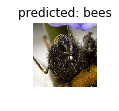

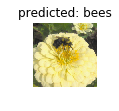

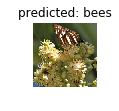

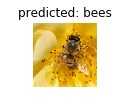

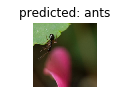

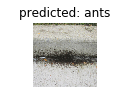

In [11]:
visualize_model(model_ft)

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
odel_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5978 Acc: 0.6575
val Loss: 0.2580 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.4013 Acc: 0.8228
val Loss: 0.2111 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.3651 Acc: 0.8228
val Loss: 0.2374 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5342 Acc: 0.7520
val Loss: 0.2234 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.6022 Acc: 0.7480
val Loss: 0.2014 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.6095 Acc: 0.7913
val Loss: 0.1989 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3290 Acc: 0.8346
val Loss: 0.2059 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4416 Acc: 0.7913
val Loss: 0.2908 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.4234 Acc: 0.8386
val Loss: 0.2028 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3980 Acc: 0.8386
val Loss: 0.2165 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3533 Acc: 0.8386
val Loss: 0.1996 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3664 Acc: 0.8465
val Loss: 0.1955 Acc: 0.9477

Ep

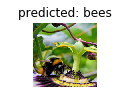

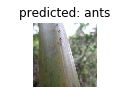

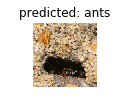

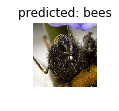

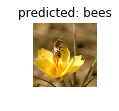

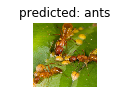

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()